# This is a part of the **practical exercise #8** on uncertainty for blood cell classification. Your task is to go through this tutorial and fill in missing code and answer the questions. 

---

First, as usual, we load needed libraries.

---


In [1]:

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
from torchvision.transforms import ToTensor, Lambda

import numpy as np

In [2]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---

Now, let's load the blood cell dataset from MedMNIST.

---



In [3]:
import medmnist
from medmnist import INFO, Evaluator

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
data_flag = 'bloodmnist'
info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


---

**Q1:** We just transformed the labels using Lambda function for defining the *DataClass* objects. Any guess why we did that?

Just keep the single label so that the task changes to single classification prediction task.
---

**Q2:** Next, we define objects of *DataLoader* class for training and testing splits. And we also define our model. Here it gets more challenging. 

In the cell below you need to:

- load a resnet18 pretrained on ImageNet network from PyTorch
- add a Dropout layer to the last fully-connected layer with 25% probability of neurons to be zeroed
- change the last layer of the resnet18 such that it outputs 8 classes (the number of classes in the blood cell dataset) instead of 1000 classes (as it is in the pretrained network)
- freeze all the layers except the last one, as we are gonna fine tune in the next step our pretrained network on the blood cell dataset

---

In [4]:
from torchvision import datasets, models, transforms
train_batch_size = 128
test_batch_size = 3

train_loader = DataLoader(
    train_set,
    batch_size=train_batch_size,
    num_workers=1,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=test_batch_size,
    num_workers=1,
    pin_memory=True,
)

# PUT YOUR CODE HERE
# load pretrained model from Pytorch
model_pretrained = models.resnet18(pretrained=True)
# freeze the model parameters
# for param in model_pretrained.parameters():
#     param.requires_grad = False

# freeze all layers

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
resnet_weights = model_pretrained.state_dict()
for k in list(resnet_weights.keys()):
  print(k, resnet_weights[k].shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
bn1.running_mean torch.Size([64])
bn1.running_var torch.Size([64])
bn1.num_batches_tracked torch.Size([])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.bn1.running_mean torch.Size([64])
layer1.0.bn1.running_var torch.Size([64])
layer1.0.bn1.num_batches_tracked torch.Size([])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.bn2.running_mean torch.Size([64])
layer1.0.bn2.running_var torch.Size([64])
layer1.0.bn2.num_batches_tracked torch.Size([])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.bn1.running_mean torch.Size([64])
layer1.1.bn1.running_var torch.Size([64])
layer1.1.bn1.num_batches_tracked torch.Size([])
layer1.1.conv2.weight torch.Size([64, 6

In [6]:
# transfer learning: add Dropout layer to final fc layer with 25% probability of neurons to be zeroed
# last layer of resnet18-> 8
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                      ('relu1', nn.ReLU()),
                      ('dropout',nn.Dropout(0.25)),
                      ('fc', nn.Linear(512, 8)),
                      ('output', nn.Softmax(dim=1))]))
model_pretrained.fc = classifier

In [7]:
model = model_pretrained.state_dict().copy()
for k in list(model.keys()):
  if not k.startswith('fc'):
    model[k].requires_grad = False

In [8]:
resnet_weights = model_pretrained.state_dict()
for k in list(resnet_weights.keys()):
  print(k, resnet_weights[k].shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
bn1.running_mean torch.Size([64])
bn1.running_var torch.Size([64])
bn1.num_batches_tracked torch.Size([])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.bn1.running_mean torch.Size([64])
layer1.0.bn1.running_var torch.Size([64])
layer1.0.bn1.num_batches_tracked torch.Size([])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.bn2.running_mean torch.Size([64])
layer1.0.bn2.running_var torch.Size([64])
layer1.0.bn2.num_batches_tracked torch.Size([])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.bn1.running_mean torch.Size([64])
layer1.1.bn1.running_var torch.Size([64])
layer1.1.bn1.num_batches_tracked torch.Size([])
layer1.1.conv2.weight torch.Size([64, 6


---



Hope you made it work! Now we are gonna fine-tune the model (the last layer of it to be more precise).  

---

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=0.001)
optimizer2 = optim.Adam(model_pretrained.fc.parameters(), lr = 0.001)
loss = []
model_pretrained.train()

for epoch in range(5):  # loop over the dataset 5 times to fine-tune the last layer 

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_pretrained(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print('\n Finished training')

100%|██████████| 94/94 [00:57<00:00,  1.63it/s]


 Finished training


---

Let's test the classification accuracy of our model.

**Q3:** Please fill in the missing code below. You need to loop over the test set and compute how many times the trained network predicts the class 
correctly.

---

In [10]:
#  set model state to eval() for running the inference
model_pretrained.eval()

correct = 0
total = 0


with torch.no_grad():
  for images, labels in tqdm(test_loader):
     y_hat = model_pretrained(images) # y_hat = 3 x 8 => 3 x 1
     loss = criterion(y_hat, labels)
     y_hat_argmax = torch.argmax(y_hat, dim=1)
     pred_ = []
     y_ = []
     for i in range(y_hat_argmax.shape[0]):
        pred_.append(y_hat_argmax[i])
        y_.append((labels[i]))
     if pred_ == y_:
        correct += 1
     total += 1
     # PUT YOUR CODE
correct/total


100%|██████████| 1141/1141 [00:26<00:00, 42.78it/s]


0.49956178790534617

---

The accuracy is ok, but not mindblowing. Thus it would be useful, as discussed in the lecture, to know how confident our model is. Let's use Monte Carlo dropout to find out. We now run 1000 forward passes and look at the distribution of the predictions.

---

In [11]:
samples = 1000
preds = []
image = next(iter(test_loader))

# compute predictions from our model with dropout
for idx in range(samples):
    preds.append(model_pretrained(image[0]).clone().detach().numpy())
preds = np.array(preds)

In [19]:
print(image[0].shape)

torch.Size([3, 3, 28, 28])


In [12]:
pred_class = []
for idx in range(preds.shape[0]):
    pred_class.append(np.argmax(preds[idx],1))

---

Now, we look at the results.

---



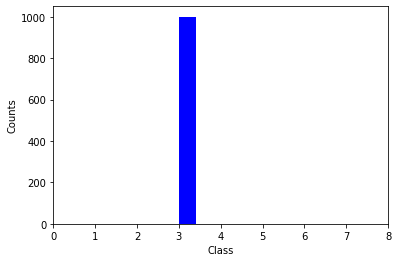

In [ ]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist([x[0] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

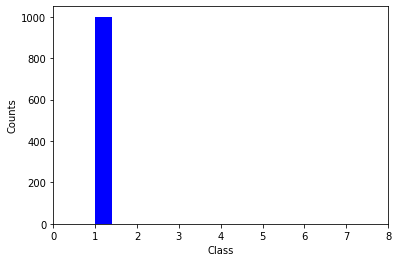

In [14]:
n, bins, patches = plt.hist([x[1] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

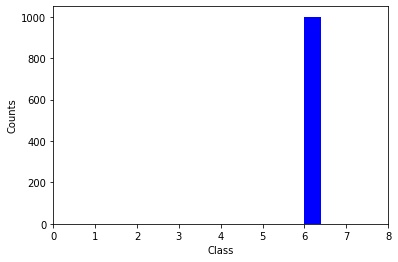

In [15]:
n, bins, patches = plt.hist([x[2] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

---

Hmm... each time, we predicted the same class 1000 times, but we expected the dropout to provide some distribution of predictions. Suspicuous...

**Q4:** Is there a catch? Please write your thoughts on why we do not see a distribution and whether we could fix it somehow.

Reason: The parameters of the model are fixed. we cannot get distribution from a single output value. If we use the same model and do T times prediction for the same sample. The prediction values are different, then we can compute distribution. Let the parameters of the model obey some distribution instead of fixed values.

---